# Leveraging AI for Predictive Chart Pattern Analysis and Liquidity Insights: A Case Study on Bitcoin Trading Trends

## Environment setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import yfinance as yf
import csv


In [2]:
file_path = 'BTCUSDT.csv'  # Đường dẫn tới file của bạn

with open(file_path, mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)  # Đọc file dưới dạng từ điển
    data = list(reader)  # Chuyển thành danh sách các hàng

# Chuyển đổi danh sách từ điển thành DataFrame
df = pd.DataFrame(data)

In [3]:
print(df.head())  # Xem 5 dòng đầu

    symbol            timestamp      open      high       low     close  \
0  BTCUSDT  2024-09-01 00:00:00   58974.0   58978.0  58957.01   58978.0   
1  BTCUSDT  2024-09-01 00:05:00   58978.0  59035.76  58975.41  59035.76   
2  BTCUSDT  2024-09-01 00:10:00  59035.75   59055.0   59023.0  59038.12   
3  BTCUSDT  2024-09-01 00:15:00  59038.11  59076.59   59024.0   59024.0   
4  BTCUSDT  2024-09-01 00:20:00   59024.0   59024.0   58991.1   58991.1   

     volume  
0  15.92811  
1  65.12076  
2  25.99014  
3  20.25307  
4  18.29866  


## Preproceeding Data

Market data

In [4]:
# Chuyển đổi các cột số từ chuỗi sang dạng số thực (nếu cần)
numeric_columns = ['open', 'high', 'low', 'close', 'volume']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Chuyển đổi và xử lý lỗi nếu có

# 1. Chuyển đổi timestamp thành datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# 2. Đổi tên cột
df.rename(columns={"Taker buy base asset volume": "taker_buy_volume"}, inplace=True)

# 3. Thêm cột mới (sự thay đổi giá giữa open và close)
df['price_change'] = df['close'] - df['open']

# 4. Xử lý dữ liệu lớn (chuẩn hóa volume)
df['volume_normalized'] = df['volume'] / df['volume'].max()

# In kết quả DataFrame đã xử lý
print(df.head())  # Xem 5 dòng đầu

    symbol           timestamp      open      high       low     close  \
0  BTCUSDT 2024-09-01 00:00:00  58974.00  58978.00  58957.01  58978.00   
1  BTCUSDT 2024-09-01 00:05:00  58978.00  59035.76  58975.41  59035.76   
2  BTCUSDT 2024-09-01 00:10:00  59035.75  59055.00  59023.00  59038.12   
3  BTCUSDT 2024-09-01 00:15:00  59038.11  59076.59  59024.00  59024.00   
4  BTCUSDT 2024-09-01 00:20:00  59024.00  59024.00  58991.10  58991.10   

     volume  price_change  volume_normalized  
0  15.92811          4.00           0.002911  
1  65.12076         57.76           0.011902  
2  25.99014          2.37           0.004750  
3  20.25307        -14.11           0.003702  
4  18.29866        -32.90           0.003344  


# ● Visualize data close price

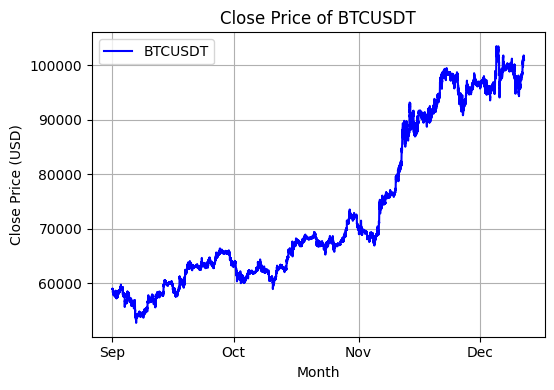

In [5]:
import math
import matplotlib.dates as mdates  # Import mdates for date formatting
# 1️⃣ Define the number of coins to display
num_coins = len(df['symbol'].unique())
num_rows = math.ceil(num_coins / 3)  # Arrange in 3 columns

# 2️⃣ Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))
axes = axes.flatten()

# 3️⃣ Plot each coin in a separate subplot
for i, coin in enumerate(df['symbol'].unique()):
    coin_data = df[df['symbol'] == coin]
    axes[i].plot(coin_data['timestamp'], coin_data['close'], label=coin, color='b')

    # Format x-axis to show only months
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Example: "Jan", "Feb", "Mar"
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())  # Set tick interval to months

    axes[i].set_title(f"Close Price of {coin}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Close Price (USD)")
    axes[i].grid(True)
    axes[i].legend()

# 4️⃣ Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Detect Outliers

- Compute First-Order Difference for Each Coin: (Hiệu sai bậc nhất) là cách tính sự thay đổi giữa giá trị hiện tại và giá trị trước đó trong một dãy số liệu.

Positive values → Price increased compared to the previous timestamp.

Negative values → Price dropped from the previous timestamp.

Spikes → Can indicate volatility or important market events.

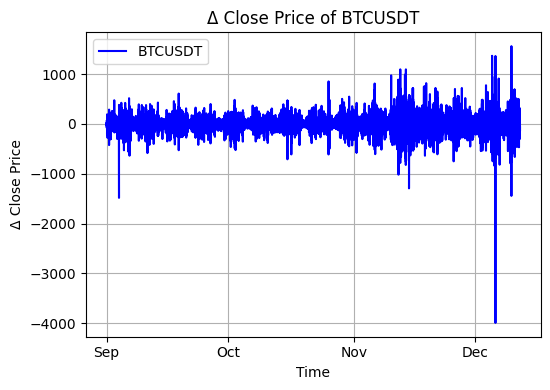

In [6]:
import math

# 1️⃣ Compute first-order difference for each coin
df['first_order_diff'] = df.groupby('symbol')['close'].diff()

# 2️⃣ Define subplot layout (3 columns)
num_coins = len(df['symbol'].unique())
num_rows = math.ceil(num_coins / 3)  # Arrange subplots in 3 columns

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))
axes = axes.flatten()

# 3️⃣ Plot each coin's first-order difference in a separate subplot
for i, coin in enumerate(df['symbol'].unique()):
    coin_data = df[df['symbol'] == coin]
    
    axes[i].plot(coin_data['timestamp'], coin_data['first_order_diff'], label=coin, color='b')
    axes[i].set_title(f"Δ Close Price of {coin}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Δ Close Price")
    axes[i].grid(True)
    axes[i].legend()

    # Format x-axis to show only months
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Example: "Jan", "Feb", "Mar"
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())  # Set tick interval to months

# 4️⃣ Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Analyze the seasonality

- Tạo boxplot 
Biểu đồ hộp (Box plot) hay còn gọi là biểu đồ hộp và râu (Box and whisker plot) là biểu đồ diễn tả 5 vị trí phân bố của dữ liệu, đó là: giá trị nhỏ nhất (min), tứ phân vị thứ nhất (Q1), trung vị (median), tứ phân vị thứ 3 (Q3) và giá trị lớn nhất (max).

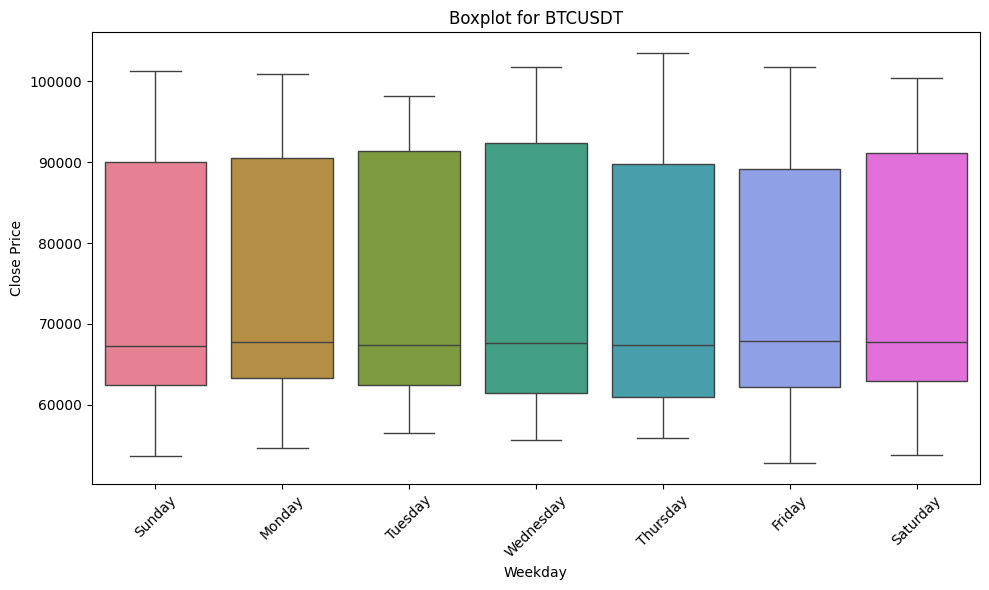

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'timestamp' is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Tạo cột Weekday_Name nếu chưa có
df['Weekday_Name'] = df['timestamp'].dt.strftime('%A')

# Drop NaN values (đặc biệt ở cột 'close' và 'Weekday_Name')
df.dropna(subset=['close', 'Weekday_Name'], inplace=True)

# Lấy coin đầu tiên trong danh sách
first_coin = df['symbol'].unique()[0]

# Lọc dữ liệu của coin đầu tiên
coin_data = df[df['symbol'] == first_coin]

# Vẽ Boxplot cho coin đầu tiên, chuyển 'Weekday_Name' vào hue và tắt legend
plt.figure(figsize=(10,6))
sns.boxplot(data=coin_data, x='Weekday_Name', y='close', hue='Weekday_Name', palette='husl', showfliers=False, dodge=False)
plt.title(f'Boxplot for {first_coin}')
plt.xlabel('Weekday')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)  # Tắt legend
plt.tight_layout()
plt.show()


# Chỉ báo kỹ thuật (Technical Indicators)

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Hàm tính VWAP
def compute_vwap(df):
    return (df['volume'] * (df['high'] + df['low'] + df['close']) / 3).cumsum() / df['volume'].cumsum()

# Hàm tính log return
def log_return(series, periods=1):
    return np.log(series / series.shift(periods))

# Hàm tính RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss.replace([np.inf, -np.inf], np.nan)
    return 100 - (100 / (1 + rs))

# Hàm tính chỉ báo kỹ thuật cho 1 coin và thêm các đặc trưng khác
def calculate_technical_indicators(df_coin):
    # Tính SMA và EMA 14 ngày cho giá đóng cửa
    df_coin['SMA_14'] = df_coin['close'].rolling(window=14).mean()
    df_coin['EMA_14'] = df_coin['close'].ewm(span=14, adjust=False).mean()
    
    # Tính RSI 14 ngày
    df_coin['RSI_14'] = compute_rsi(df_coin['close'], period=14)
    
    # Tính MACD và Signal Line
    short_ema = df_coin['close'].ewm(span=12, adjust=False).mean()
    long_ema = df_coin['close'].ewm(span=26, adjust=False).mean()
    df_coin['MACD'] = short_ema - long_ema
    df_coin['Signal_Line'] = df_coin['MACD'].ewm(span=9, adjust=False).mean()
    
    # Tính Bollinger Bands (dùng 20 phiên)
    rolling_mean = df_coin['close'].rolling(window=20).mean()
    rolling_std = df_coin['close'].rolling(window=20).std()
    df_coin['Bollinger_Upper'] = rolling_mean + 2 * rolling_std
    df_coin['Bollinger_Lower'] = rolling_mean - 2 * rolling_std
    
    # Tính ATR 14 ngày (sử dụng True Range)
    df_coin['TR'] = np.maximum(df_coin['high'] - df_coin['low'],
                           np.maximum(abs(df_coin['high'] - df_coin['close'].shift(1)),
                                      abs(df_coin['low'] - df_coin['close'].shift(1))))
    df_coin['ATR_14'] = df_coin['TR'].rolling(window=14).mean()
    
    # Thêm các đặc trưng liên quan đến thời gian
    df_coin['Weekday'] = df_coin['timestamp'].dt.dayofweek    # 0 = Monday, 6 = Sunday
    df_coin['Hour'] = df_coin['timestamp'].dt.hour
    
    # Các đặc trưng liên quan đến nến
    df_coin['body_size'] = (df_coin['close'] - df_coin['open']).abs()       # Kích thước thân nến
    df_coin['candle_range'] = df_coin['high'] - df_coin['low']                # Toàn bộ phạm vi của nến
    df_coin['body_ratio'] = df_coin['body_size'] / df_coin['candle_range']      # Tỷ lệ thân nến so với toàn bộ
    
    # Đặc trưng khối lượng
    df_coin['volume_mean_20'] = df_coin['volume'].rolling(window=20).mean()
    df_coin['volume_ratio'] = df_coin['volume'] / df_coin['volume_mean_20']
    
    # Tính VWAP
    df_coin['vwap'] = compute_vwap(df_coin)
    
     # Target column: Residualized return trong 15 phút tới
    df_coin['log_return_15min'] = log_return(df_coin['close'], periods=15)
    df_coin['SMA_return_15min'] = df_coin['log_return_15min'].rolling(window=15).mean()
    df_coin['target_residual'] = df_coin['log_return_15min'] - df_coin['SMA_return_15min']

    
    # Loại bỏ các dòng có giá trị NaN do quá trình tính toán
    return df_coin.dropna()


In [9]:
# Đọc dữ liệu, parse cột timestamp
df = pd.read_csv('BTCUSDT.csv', parse_dates=['timestamp'])

# Lọc dữ liệu của coin BTC (giả sử cột 'symbol' có chứa mã coin)
df_btc = df[df['symbol'] == 'BTCUSDT']

# Tính các chỉ báo kỹ thuật và các đặc trưng cho coin BTC
df_btc_technical = calculate_technical_indicators(df_btc)

# Hiển thị 5 dòng đầu của DataFrame sau khi tính chỉ báo
print(df_btc_technical.head())

     symbol           timestamp      open      high       low     close  \
29  BTCUSDT 2024-09-01 02:25:00  58445.87  58445.87  58280.00  58315.00   
30  BTCUSDT 2024-09-01 02:30:00  58314.99  58441.51  58276.01  58435.00   
31  BTCUSDT 2024-09-01 02:35:00  58435.00  58520.78  58428.00  58504.01   
32  BTCUSDT 2024-09-01 02:40:00  58504.00  58560.18  58470.50  58480.00   
33  BTCUSDT 2024-09-01 02:45:00  58480.00  58490.00  58429.47  58440.00   

       volume        SMA_14        EMA_14     RSI_14  ...  Hour  body_size  \
29  148.71864  58754.475714  58692.505033   9.718769  ...     2     130.87   
30  146.98020  58718.832857  58658.171029  20.711150  ...     2     120.01   
31   79.11355  58688.976429  58637.616225  27.004962  ...     2      69.01   
32   75.08041  58658.976429  58616.600728  26.945372  ...     2      24.00   
33   38.87876  58628.357143  58593.053965  26.691316  ...     2      40.00   

    candle_range  body_ratio  volume_mean_20  volume_ratio          vwap  \
29  

# Visualization 

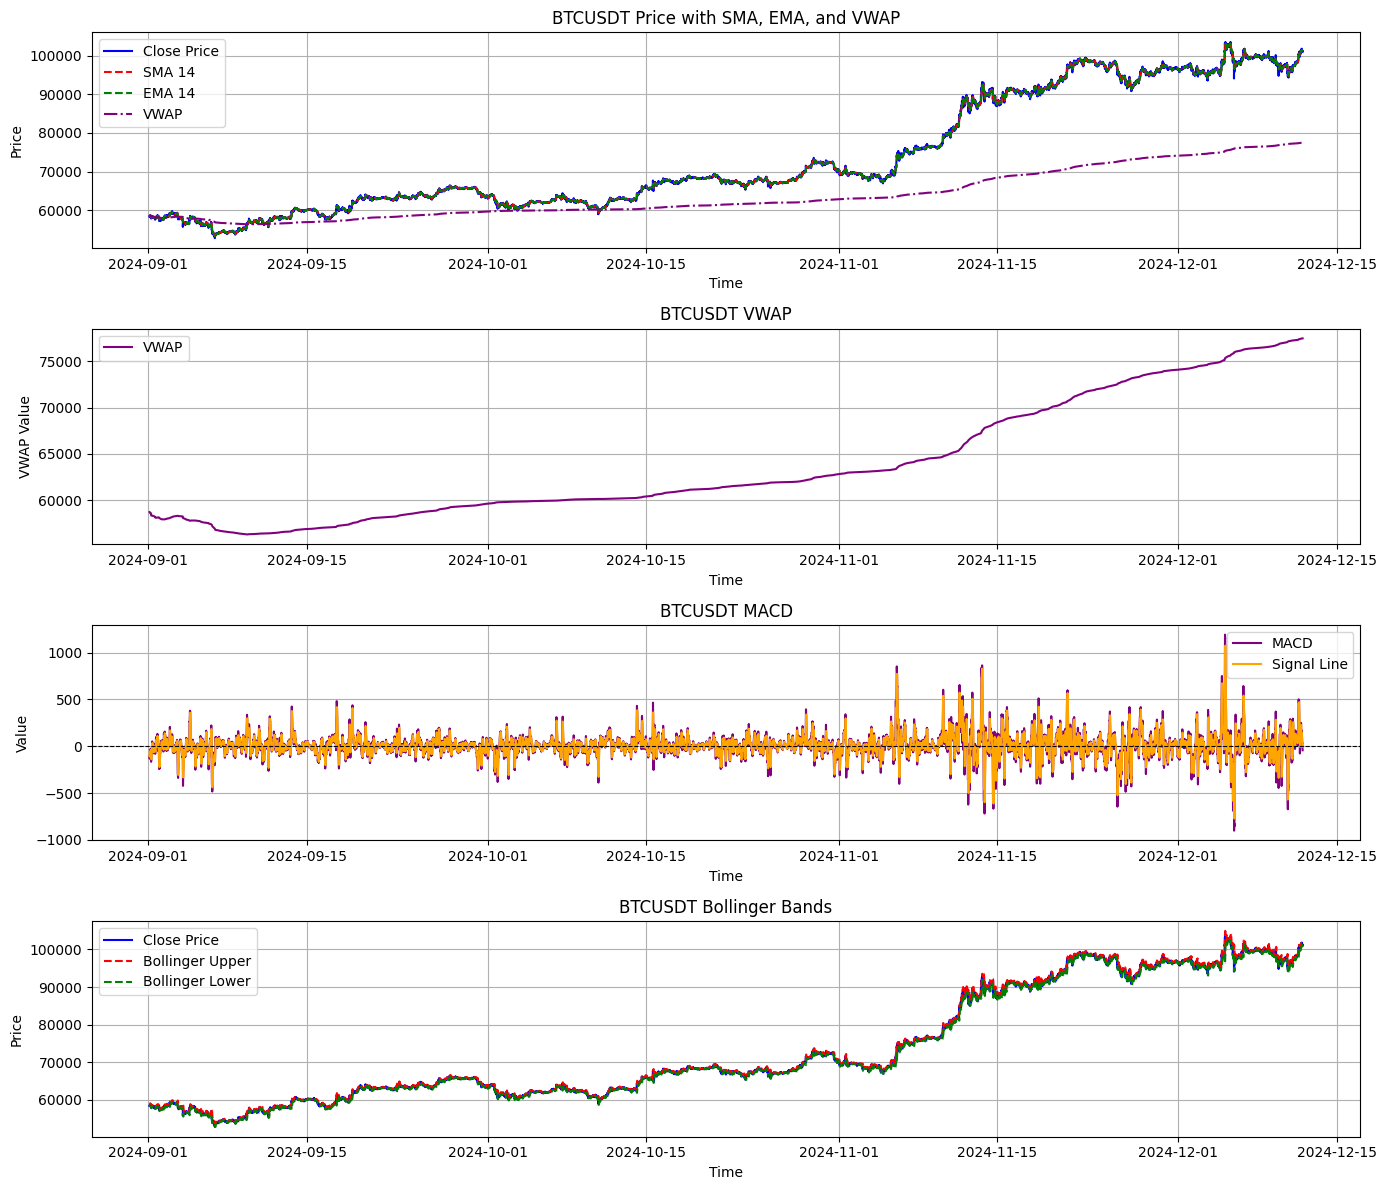

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))

# Biểu đồ giá đóng cửa + SMA, EMA, VWAP
plt.subplot(4, 1, 1)
plt.plot(df_btc_technical['timestamp'], df_btc_technical['close'], label='Close Price', color='blue')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['SMA_14'], label='SMA 14', color='red', linestyle='--')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['EMA_14'], label='EMA 14', color='green', linestyle='--')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['vwap'], label='VWAP', color='purple', linestyle='-.')
plt.title('BTCUSDT Price with SMA, EMA, and VWAP')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Biểu đồ VWAP riêng biệt
plt.subplot(4, 1, 2)
plt.plot(df_btc_technical['timestamp'], df_btc_technical['vwap'], label='VWAP', color='purple')
plt.title('BTCUSDT VWAP')
plt.xlabel('Time')
plt.ylabel('VWAP Value')
plt.legend()
plt.grid(True)

# Biểu đồ MACD với đường 0
plt.subplot(4, 1, 3)
plt.plot(df_btc_technical['timestamp'], df_btc_technical['MACD'], label='MACD', color='purple')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['Signal_Line'], label='Signal Line', color='orange')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # Thêm đường 0
plt.title('BTCUSDT MACD')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Biểu đồ Bollinger Bands với vùng bóng mờ
plt.subplot(4, 1, 4)
plt.plot(df_btc_technical['timestamp'], df_btc_technical['close'], label='Close Price', color='blue')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['Bollinger_Upper'], label='Bollinger Upper', color='red', linestyle='--')
plt.plot(df_btc_technical['timestamp'], df_btc_technical['Bollinger_Lower'], label='Bollinger Lower', color='green', linestyle='--')
plt.fill_between(df_btc_technical['timestamp'], df_btc_technical['Bollinger_Lower'], df_btc_technical['Bollinger_Upper'], color='gray', alpha=0.3)  # Bóng mờ
plt.title('BTCUSDT Bollinger Bands')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Using CNN

In [11]:
import mlflow
import mlflow.tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Định nghĩa thư mục dataset
dataset_dir = "D:\\Kế hoạch kinh doanh\\Crypto Detection\\CryptoPrediction\\DATASET_CHART_PATTERN"

# Chuẩn bị dữ liệu train và validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    dataset_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training'
)
val_generator = train_datagen.flow_from_directory(
    dataset_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation'
)

# Xây dựng mô hình CNN
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile mô hình
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Đường dẫn lưu mô hình mới
model_path = "D:\\Crypto_Detection\\CryptoPrediction\\saved_model_new"

# Bắt đầu chạy MLflow
with mlflow.start_run():
    mlflow.tensorflow.autolog()  # Tự động log thông tin mô hình
    
    # Huấn luyện mô hình
    history = model_cnn.fit(train_generator, validation_data=val_generator, epochs=50)
    
    # Lưu lại mô hình
    mlflow.tensorflow.save_model(model_cnn, model_path)
    
    # Log mô hình dưới dạng artifact
    mlflow.log_artifact(model_path)
    
    print("Model training completed and logged in MLflow.")

Found 168 images belonging to 7 classes.
Found 42 images belonging to 7 classes.


2025/02/27 20:36:32 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/02/27 20:36:32 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 2.5580 - accuracy: 0.1607

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 6s 868ms/step - loss: 2.5580 - accuracy: 0.1607 - val_loss: 1.9458 - val_accuracy: 0.1429
Epoch 2/50
6/6 [==============================] - 5s 861ms/step - loss: 1.9291 - accuracy: 0.2262 - val_loss: 1.9113 - val_accuracy: 0.1429
Epoch 3/50
6/6 [==============================] - 5s 859ms/step - loss: 1.8266 - accuracy: 0.3214 - val_loss: 1.6440 - val_accuracy: 0.5238
Epoch 4/50
6/6 [==============================] - 5s 895ms/step - loss: 1.2901 - accuracy: 0.6548 - val_loss: 1.0504 - val_accuracy: 0.6429
Epoch 5/50
6/6 [==============================] - 5s 874ms/step - loss: 0.6004 - accuracy: 0.8452 - val_loss: 0.9156 - val_accuracy: 0.6905
Epoch 6/50
6/6 [==============================] - 3s 566ms/step - loss: 0.3778 - accuracy: 0.8869 - val_loss: 1.0423 - val_accuracy: 0.6905
Epoch 7/50
6/6 [==============================] - 3s 504ms/step - loss: 0.2494 - accuracy: 0.9048 - val_loss: 1.3073 - val_accuracy: 0.6667
Epoch 8/50
6/6 [===============

2025/02/27 20:38:51 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/02/27 20:38:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp_gd2371t\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp_gd2371t\model\data\model\assets
2025/02/27 20:38:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/02/27 20:39:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: D:\Crypto_Detection\CryptoPrediction\saved_model_new\data\model\assets


INFO:tensorflow:Assets written to: D:\Crypto_Detection\CryptoPrediction\saved_model_new\data\model\assets


Model training completed and logged in MLflow.


In [12]:
# Đánh giá trên tập validation hoặc test
test_loss, test_acc = model_cnn.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.4f}")

2/2 [==============================] - 0s 29ms/step - loss: 3.1833 - accuracy: 0.6905
Test Accuracy: 0.69
Test Loss: 3.1833


In [13]:
import numpy as np

# Lấy toàn bộ dữ liệu từ val_generator để tạo X_test
X_test, y_test = [], []
for _ in range(len(val_generator)):
    x_batch, y_batch = val_generator.next()
    X_test.extend(x_batch)
    y_test.extend(y_batch)

# Chuyển về numpy array
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Shape of X_test:", X_test.shape)  # (số lượng ảnh, 128, 128, 3)
print("Shape of y_test:", y_test.shape)  # (số lượng ảnh, số classes)

Shape of X_test: (42, 128, 128, 3)
Shape of y_test: (42, 7)


2025/02/27 20:39:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '93d803ff0f3b41bc96accae7d3357920', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/02/27 20:39:05 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/02/27 20:39:05 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 3.2612e-06 - accuracy: 1.0000

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 5s 822ms/step - loss: 3.2612e-06 - accuracy: 1.0000 - val_loss: 3.1688 - val_accuracy: 0.6905
Epoch 2/50
6/6 [==============================] - 3s 413ms/step - loss: 3.1924e-06 - accuracy: 1.0000 - val_loss: 3.1879 - val_accuracy: 0.6905
Epoch 3/50
6/6 [==============================] - 3s 413ms/step - loss: 2.8830e-06 - accuracy: 1.0000 - val_loss: 3.2090 - val_accuracy: 0.6905
Epoch 4/50
6/6 [==============================] - 2s 400ms/step - loss: 2.6943e-06 - accuracy: 1.0000 - val_loss: 3.1897 - val_accuracy: 0.6905
Epoch 5/50
6/6 [==============================] - 2s 381ms/step - loss: 2.4523e-06 - accuracy: 1.0000 - val_loss: 3.1902 - val_accuracy: 0.6905
Epoch 6/50
6/6 [==============================] - 2s 389ms/step - loss: 2.3175e-06 - accuracy: 1.0000 - val_loss: 3.1992 - val_accuracy: 0.6905
Epoch 7/50
6/6 [==============================] - 2s 383ms/step - loss: 2.1883e-06 - accuracy: 1.0000 - val_loss: 3.2041 - val_accuracy: 0.6905
Epo

2025/02/27 20:41:07 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/02/27 20:41:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp0n92s_0q\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp0n92s_0q\model\data\model\assets
2025/02/27 20:41:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


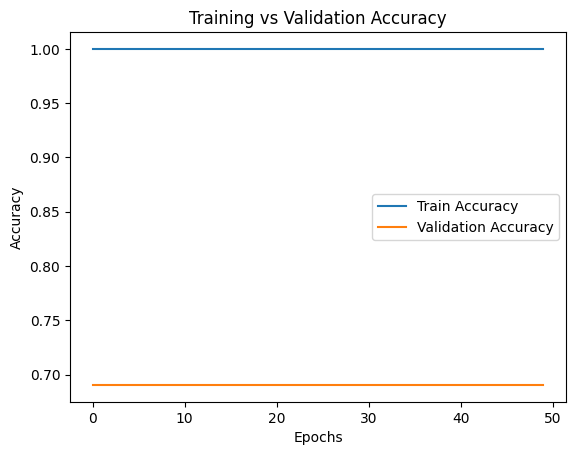

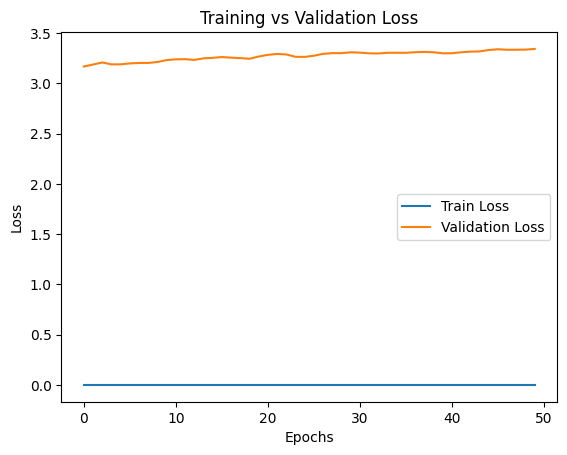

In [14]:
import matplotlib.pyplot as plt

# Giả sử bạn có history từ model.fit()
history = model_cnn.fit(train_generator, validation_data=val_generator, epochs=50)

# Vẽ Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# Vẽ Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


2/2 [==============================] - 0s 27ms/step


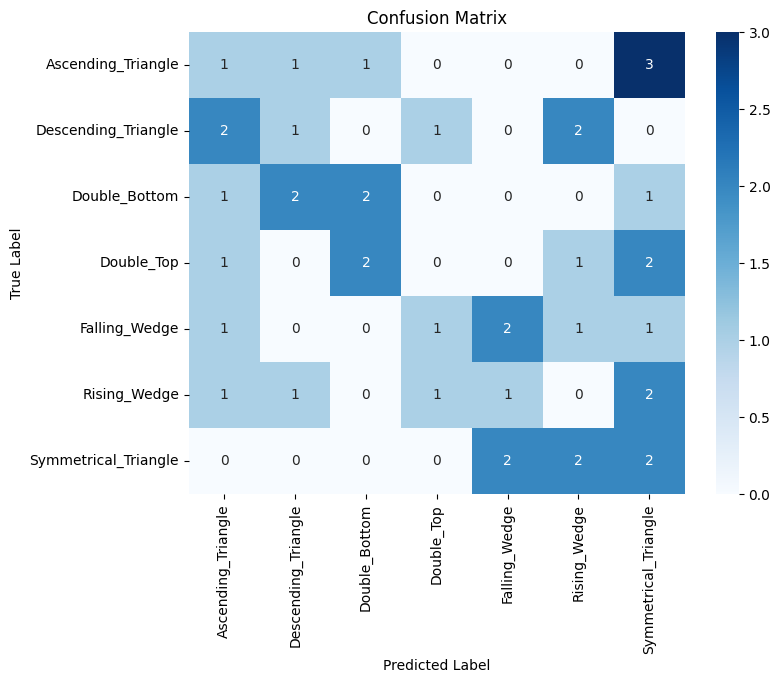

In [15]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Dự đoán trên tập validation
y_pred = model_cnn.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Lấy class có xác suất cao nhất
y_true = val_generator.classes  # Nhãn thực tế

# Vẽ Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Feature Extraction

In [16]:
from tensorflow.keras.models import Model
import numpy as np

# Giả sử bạn đã có mô hình CNN đã train xong
base_model = model_cnn  # Load mô hình đã train

# Chọn lớp cuối cùng trước lớp Dense để trích xuất đặc trưng
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Trích xuất đặc trưng từ ảnh
features = feature_extractor.predict(X_test)  # X_test là tập ảnh bạn muốn trích xuất đặc trưng

# Lưu thành file .csv để dùng cho các mô hình khác
np.savetxt("cnn_features.csv", features, delimiter=",")


2/2 [==============================] - 0s 40ms/step


# Chuẩn bị dữ liệu để Train mô hình

## Test lại dữ liệu

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Đọc đặc trưng kỹ thuật từ file CSV
df_technical = pd.read_csv("BTCUSDT.csv", parse_dates=['timestamp'])

# Đọc đặc trưng từ CNN
cnn_features = np.loadtxt("cnn_features.csv", delimiter=",")

# Đảm bảo số dòng của df_technical và cnn_features phải khớp nhau (hoặc cắt bớt nếu cần)
if len(df_technical) > len(cnn_features):
    df_technical = df_technical.iloc[-len(cnn_features):]  # Cắt cho khớp số lượng dòng
elif len(cnn_features) > len(df_technical):
    cnn_features = cnn_features[-len(df_technical):]  # Cắt bỏ phần thừa

# Tính chỉ báo kỹ thuật từ df_technical
df_technical = calculate_technical_indicators(df_technical)

# Chọn tập đặc trưng kỹ thuật
features = [
    'open', 'high', 'low', 'close', 'volume', 
    'vwap', 'SMA_14', 'EMA_14', 'RSI_14', 'MACD', 'Signal_Line', 
    'Bollinger_Upper', 'Bollinger_Lower', 'ATR_14', 
    'Weekday', 'Hour', 'body_size', 'candle_range', 'body_ratio', 'volume_ratio',
    'log_return_15min', 'SMA_return_15min', 'target_residual'
]

X_technical = df_technical[features]

# Chuẩn hóa đặc trưng kỹ thuật
scaler = StandardScaler()
X_technical_scaled = scaler.fit_transform(X_technical)

cnn_features = cnn_features[-X_technical_scaled.shape[0]:]

# Ghép đặc trưng CNN vào đặc trưng kỹ thuật
X_combined = np.hstack((X_technical_scaled, cnn_features))

# Chuyển đổi X_combined từ numpy.ndarray sang pandas.DataFrame
X_combined_df = pd.DataFrame(X_combined, columns=[*features, *[f'cnn_feature_{i}' for i in range(cnn_features.shape[1])]])

# Xác định nhãn y
y = (df_technical['log_return_15min'] > 0).astype(int)

# Chia train-test (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, shuffle=False)

# Kiểm tra kích thước dữ liệu
print("Số đặc trưng kỹ thuật:", X_technical_scaled.shape[1])
print("Số đặc trưng CNN:", cnn_features.shape[1])
print("Tổng số đặc trưng:", X_combined.shape[1])
print("Số mẫu train:", X_train.shape[0])
print("Số mẫu test:", X_test.shape[0])

Số đặc trưng kỹ thuật: 23
Số đặc trưng CNN: 512
Tổng số đặc trưng: 535
Số mẫu train: 10
Số mẫu test: 3


In [26]:
# Kiểm tra tổng số hàng trong DataFrame
total_rows = df_technical.shape[0]
print("Tổng số hàng trong BTCUSDT.csv:", total_rows)

Tổng số hàng trong BTCUSDT.csv: 13


# USING LIGHTGBM

pip install lightgbm optuna mlflow


In [2]:
import lightgbm as lgb
import optuna
import mlflow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Tạo dataset cho LightGBM
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test, label=y_test)

# Bắt đầu theo dõi với MLflow
mlflow.set_experiment("LightGBM_Regression_Crypto")

with mlflow.start_run():
    # Ghi lại thông tin về tập dữ liệu
    mlflow.log_param("features", X_combined_df.columns.tolist())
    mlflow.log_param("train_size", X_train.shape[0])
    mlflow.log_param("test_size", X_test.shape[0])
    
    # Hàm objective để tối ưu hóa tham số bằng Optuna
    def objective(trial):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            #Sửa lại các tham số để tối ưu hóa Learning Rate, Num Leaves, Max Depth, Reg Alpha, Reg Lambda
            'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.05, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 80),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1e-1, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1e-1, log=True),
            'n_estimators': 500,
            'feature_pre_filter': False  # Cần thêm để tránh lỗi khi giảm min_data_in_leaf
        }
        # Huấn luyện với lgb.train() dùng callback early_stopping
        model = lgb.train(
            params=params,
            train_set=dtrain,
            valid_sets=[dvalid],
            num_boost_round=500,
            callbacks=[
                lgb.early_stopping(stopping_rounds=30),
                lgb.log_evaluation(period=50)
            ]
        )
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        return mean_squared_error(y_test, y_pred)
    
    # Tạo study và tối ưu hóa với 20 trial
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)
    best_params = study.best_params
    mlflow.log_params(best_params)
    
    # Huấn luyện mô hình với tham số tối ưu
    final_params = {
        **best_params,
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt"
    }
    model = lgb.train(
        params=final_params,
        train_set=dtrain,
        valid_sets=[dvalid],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )
    
    # Ghi lại mô hình vào MLflow
    mlflow.lightgbm.log_model(model, "lightgbm_model")
    
    # Dự đoán và đánh giá mô hình
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    mse = mean_squared_error(y_test, y_pred)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", np.sqrt(mse))
    mlflow.log_metric("MAE", mean_absolute_error(y_test, y_pred))
    mlflow.end_run()

best_params, mse

NameError: name 'X_train' is not defined

In [ ]:
# Huấn luyện mô hình LightGBM với tham số tối ưu
model = lgb.train(
    params={**best_params, "objective": "regression", "metric": "rmse", "boosting_type": "gbdt"},
    train_set=dtrain,
    valid_sets=[dvalid],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Ghi lại mô hình vào MLflow
mlflow.lightgbm.log_model(model, "lightgbm_model")

# Dự đoán trên tập test
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))
r2 = 1 - (mse / np.var(y_test))

mlflow.log_metric("MSE", mse)
mlflow.log_metric("MAE", mae)
mlflow.log_metric("R2", r2)

# Vẽ biểu đồ so sánh kết quả dự đoán và thực tế
plt.figure(figsize=(14,7))
plt.plot(y_test.values, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='green', linestyle='dashed')
plt.fill_between(range(len(y_test)), y_test, y_pred, color='gray', alpha=0.2, label='Prediction Error')
plt.title("LightGBM Model Prediction vs Actual Price")
plt.xlabel("Time (Test Samples)")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("lightgbm_prediction_plot.png")
mlflow.log_artifact("lightgbm_prediction_plot.png")

print("Best Parameters:", best_params)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

mlflow.end_run()

best_params, mse, mae, r2

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dự đoán trên tập train và test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Tính toán các chỉ số
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train}, Test MSE: {mse_test}")
print(f"Train MAE: {mae_train}, Test MAE: {mae_test}")
print(f"Train R²: {r2_train}, Test R²: {r2_test}")


# Visualize result

## Vẽ Biểu đồ Residual Plot
- Đánh giá độ lệch của dự đoán so với thực tế bằng residual plot. Residuals (sai số dự đoán) nên phân bố đều xung quanh trục 0.

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals)), residuals, color="purple", alpha=0.6, label="Residuals")
plt.axhline(0, color="red", linestyle="--", label="Zero Error Line")
plt.xlabel("Test Sample Index")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.legend()
plt.grid(True)
plt.show()


## Vẽ Biểu đồ KDE của Residuals
- Kiểm tra phân phối của sai số dự đoán để xem có bị lệch hoặc có mô hình đang thiên vị không.

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(residuals, color="green", fill=True)
plt.axvline(0, color="red", linestyle="--", label="Zero Error Line")
plt.title("KDE Plot of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


## Vẽ Biểu đồ Error Distribution (Histogram)
- Kiểm tra xem sai số có phân bố chuẩn không.

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, color="orange", edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", label="Zero Error Line")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.legend()
plt.grid(True)
plt.show()


# Using XGBoost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.xgboost

In [ ]:
# Bắt đầu theo dõi quá trình training với MLflow
mlflow.set_experiment("XGBoost_Regression_Crypto")
with mlflow.start_run():
    # Ghi lại thông số tiền xử lý
    mlflow.log_param("features", X.columns.tolist())
    mlflow.log_param("train_size", X_train.shape[0])
    mlflow.log_param("test_size", X_test.shape[0])
    
    # Định nghĩa GridSearchCV cho XGBoost
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    mlflow.log_params(best_params)
    
    # Xây dựng mô hình XGBoost với tham số tối ưu
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42,
                              n_estimators=best_params['n_estimators'],
                              max_depth=best_params['max_depth'],
                              learning_rate=best_params['learning_rate'],
                              subsample=best_params['subsample'])
    xgb_model.fit(X_train, y_train)
    
    # Ghi lại mô hình vào MLflow
    mlflow.xgboost.log_model(xgb_model, "xgb_model")
    
    # Dự đoán trên tập test
    y_pred_xgb = xgb_model.predict(X_test)
    
    # Đánh giá mô hình
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    
    mlflow.log_metric("MSE", mse_xgb)
    mlflow.log_metric("MAE", mae_xgb)
    mlflow.log_metric("R2", r2_xgb)
    
    # Vẽ biểu đồ so sánh dự đoán và giá thực
    plt.figure(figsize=(14,7))
    plt.plot(y_test.values, label='Actual Price', color='blue')
    plt.plot(y_pred_xgb, label='XGBoost Predicted Price', color='green', linestyle='dashed')
    plt.fill_between(range(len(y_test)), y_test, y_pred_xgb, color='gray', alpha=0.2, label='Prediction Error')
    plt.title("XGBoost Model Prediction vs Actual Price")
    plt.xlabel('Time (Test Samples)')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("xgb_prediction_plot.png")
    mlflow.log_artifact("xgb_prediction_plot.png")
    
    print("Best Parameters:", best_params)
    print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
    print(f"Mean Absolute Error (MAE): {mae_xgb:.4f}")
    print(f"R2 Score: {r2_xgb:.4f}")
    
    mlflow.end_run()


## Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dự đoán trên tập train và test
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Tính toán các chỉ số đánh giá mô hình
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# In kết quả
print(f"Train MSE: {mse_train:.6f}, Test MSE: {mse_test:.6f}")
print(f"Train MAE: {mae_train:.6f}, Test MAE: {mae_test:.6f}")
print(f"Train R²: {r2_train:.6f}, Test R²: {r2_test:.6f}")

# Kiểm tra Overfitting
if r2_train > 0.98 and r2_test < 0.85:
    print("⚠️ Mô hình có dấu hiệu overfitting! Cần điều chỉnh hyperparameter.")


# Using GRU

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import mlflow
import mlflow.tensorflow
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Chuẩn bị dữ liệu (giả sử X_train, X_test, y_train, y_test đã có sẵn)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape dữ liệu để phù hợp với mô hình GRU
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Bắt đầu theo dõi với MLflow
mlflow.set_experiment("GRU_Regression_Crypto")
with mlflow.start_run():
    # Ghi lại thông số tiền xử lý
    mlflow.log_param("features", X.columns.tolist())
    mlflow.log_param("train_size", X_train.shape[0])
    mlflow.log_param("test_size", X_test.shape[0])

    # Xây dựng mô hình GRU
    gru_model = Sequential([
        GRU(units=64, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
        Dropout(0.2),
        GRU(units=32, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    # Train model
    history = model.fit(X_train_reshaped, y_train, epochs=70, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=1)

    # Ghi lại mô hình vào MLflow
    mlflow.tensorflow.log_model(model, "gru_model")

    # Dự đoán trên tập test
    y_pred_gru = model.predict(X_test_reshaped)

    # Đánh giá mô hình
    mse_gru = mean_squared_error(y_test, y_pred_gru)
    mae_gru = mean_absolute_error(y_test, y_pred_gru)
    r2_gru = r2_score(y_test, y_pred_gru)

    mlflow.log_metric("MSE", mse_gru)
    mlflow.log_metric("MAE", mae_gru)
    mlflow.log_metric("R2", r2_gru)

    # Vẽ biểu đồ dự đoán so với giá thực tế
    plt.figure(figsize=(14,7))
    plt.plot(y_test.values, label='Actual Price', color='blue')
    plt.plot(y_pred_gru, label='GRU Predicted Price', color='red', linestyle='dashed')
    plt.fill_between(range(len(y_test)), y_test.values.flatten(), y_pred_gru.flatten(), color='gray', alpha=0.2, label='Prediction Error')
    plt.title("GRU Model Prediction vs Actual Price")
    plt.xlabel('Time (Test Samples)')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("gru_prediction_plot.png")
    mlflow.log_artifact("gru_prediction_plot.png")

    print(f"Mean Squared Error (MSE): {mse_gru:.4f}")
    print(f"Mean Absolute Error (MAE): {mae_gru:.4f}")
    print(f"R2 Score: {r2_gru:.4f}")

    mlflow.end_run()


# Evaluation Train set and 

# Using NAR

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import mlflow
import mlflow.tensorflow
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Chuẩn bị dữ liệu (giả sử X_train, X_test, y_train, y_test đã có sẵn)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape dữ liệu để phù hợp với mô hình GRU NAR
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Bắt đầu theo dõi với MLflow
mlflow.set_experiment("NAR_GRU_Regression_Crypto")
with mlflow.start_run():
    # Ghi lại thông số tiền xử lý
    mlflow.log_param("features", X.columns.tolist())
    mlflow.log_param("train_size", X_train.shape[0])
    mlflow.log_param("test_size", X_test.shape[0])

    # Xây dựng mô hình NAR-GRU
    nar_model = Sequential([
        GRU(units=64, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
        Dropout(0.2),
        GRU(units=32, return_sequences=False),
        Dropout(0.2),
        Dense(units=25, activation="relu"),
        Dense(units=1)  # Dự báo trực tiếp không cần autoregressive loop
    ])

    nar_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

    # Train model
    history_nar = nar_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_test_reshaped, y_test), verbose=1)

    # Ghi lại mô hình vào MLflow
    mlflow.tensorflow.log_model(nar_model, "nar_gru_model")

    # Dự đoán trên tập test
    y_pred_nar = nar_model.predict(X_test_reshaped)

    # Đánh giá mô hình
    mse_nar = mean_squared_error(y_test, y_pred_nar)
    mae_nar = mean_absolute_error(y_test, y_pred_nar)
    r2_nar = r2_score(y_test, y_pred_nar)

    mlflow.log_metric("MSE", mse_nar)
    mlflow.log_metric("MAE", mae_nar)
    mlflow.log_metric("R2", r2_nar)

    # Vẽ biểu đồ dự đoán so với giá thực tế
    plt.figure(figsize=(14,7))
    plt.plot(y_test.values, label='Actual Price', color='blue')
    plt.plot(y_pred_nar, label='NAR-GRU Predicted Price', color='green', linestyle='dashed')
    plt.fill_between(range(len(y_test)), y_test.values.flatten(), y_pred_nar.flatten(), color='gray', alpha=0.2, label='Prediction Error')
    plt.title("NAR-GRU Model Prediction vs Actual Price")
    plt.xlabel('Time (Test Samples)')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("nar_gru_prediction_plot.png")
    mlflow.log_artifact("nar_gru_prediction_plot.png")

    print(f"NAR-GRU Mean Squared Error (MSE): {mse_nar:.4f}")
    print(f"NAR-GRU Mean Absolute Error (MAE): {mae_nar:.4f}")
    print(f"NAR-GRU R2 Score: {r2_nar:.4f}")

    mlflow.end_run()


# Using model History Bits

History Bits là một phương pháp mã hóa lịch sử giá dưới dạng chuỗi nhị phân (0 hoặc 1), giúp nhận diện xu hướng giá.

- 1: Khi giá đóng cửa cao hơn giá mở cửa (nến xanh).
- 0: Khi giá đóng cửa thấp hơn giá mở cửa (nến đỏ).
Chuỗi bit lịch sử (history bits) giúp mô hình nhận diện xu hướng giá.

1. Tạo Function để Sinh Tín hiệu


In [ ]:
import pandas as pd
import numpy as np

# Giả lập dữ liệu BTCUSDT
df = pd.DataFrame({
    'timestamp': pd.date_range(start='2024-09-01', periods=100, freq='5T'),
    'open': np.random.randint(58000, 60000, 100),
    'high': np.random.randint(58000, 60000, 100),
    'low': np.random.randint(58000, 60000, 100),
    'close': np.random.randint(58000, 60000, 100)
})

# Tạo History Bits
df['history_bits'] = (df['close'] > df['open']).astype(int)

# Xem dữ liệu mới
print(df[['timestamp', 'open', 'close', 'history_bits']].head(10))


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Chọn các đặc trưng cho mô hình
features = ['open', 'high', 'low', 'close', 'history_bits']
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

# Chia tập dữ liệu thành X (input) và y (output)
seq_length = 10  # Dùng 10 phiên gần nhất để dự đoán
X, y = [], []

for i in range(seq_length, len(df_scaled)):
    X.append(df_scaled[i-seq_length:i])
    y.append(df_scaled[i, -2])  # Dự đoán giá đóng cửa

X, y = np.array(X), np.array(y)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile mô hình
model.compile(optimizer='adam', loss='mse')

# Train mô hình
model.fit(X, y, epochs=50, batch_size=16)


In [ ]:
def generate_trading_signal(model, recent_data, scaler, support, resistance):
    # Chuyển đổi dữ liệu
    recent_data = np.expand_dims(recent_data, axis=0)
    predicted_price = model.predict(recent_data)

    # Chuyển về giá thực tế
    predicted_price_actual = scaler.inverse_transform(
        np.hstack((np.zeros((predicted_price.shape[0], len(features) - 1)), predicted_price))
    )[:, -1]

    # Giá hiện tại
    current_price_actual = scaler.inverse_transform(
        np.hstack((np.zeros((1, len(features) - 1)), np.array([[recent_data[0][-1][3]]])))
    )[:, -1][0]

    # Tạo tín hiệu dựa trên History Bits
    last_5_bits = "".join(map(str, recent_data[0, -5:, -1].astype(int)))

    if predicted_price_actual[0] > resistance and last_5_bits.count("1") >= 4:
        return "SELL"
    elif predicted_price_actual[0] < support and last_5_bits.count("0") >= 4:
        return "BUY"
    else:
        return "HOLD"


# Xác định Vùng Kháng Cự và Hỗ Trợ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tính các đường trung bình động
df['MA20'] = df['close'].rolling(window=20).mean()
df['MA50'] = df['close'].rolling(window=50).mean()
df['MA200'] = df['close'].rolling(window=200).mean()

# Vẽ biểu đồ giá và các đường MA
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['close'], label="Close Price", color='blue')
plt.plot(df['timestamp'], df['MA20'], label="MA20 (Support/Resistance)", linestyle='dotted', color='red')
plt.plot(df['timestamp'], df['MA50'], label="MA50", linestyle='dashed', color='green')
plt.plot(df['timestamp'], df['MA200'], label="MA200", linestyle='solid', color='black')
plt.legend()
plt.title("Vùng Kháng Cự/Hỗ Trợ Dựa trên MA")
plt.show()


# Dùng Pivot Points để Xác định Mức Giá Quan Trọng

In [ ]:
df['PP'] = (df['high'] + df['low'] + df['close']) / 3
df['R1'] = (2 * df['PP']) - df['low']
df['S1'] = (2 * df['PP']) - df['high']

# Vẽ biểu đồ
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['close'], label="Close Price", color='blue')
plt.plot(df['timestamp'], df['PP'], label="Pivot Point", linestyle='dotted', color='black')
plt.plot(df['timestamp'], df['R1'], label="Resistance 1", linestyle='dashed', color='red')
plt.plot(df['timestamp'], df['S1'], label="Support 1", linestyle='dashed', color='green')
plt.legend()
plt.title("Pivot Points - Vùng Kháng Cự & Hỗ Trợ")
plt.show()


# Xác định Vùng Hỗ Trợ/Kháng Cự bằng ATR

In [ ]:
df['ATR'] = df['high'].rolling(14).max() - df['low'].rolling(14).min()
df['Resistance'] = df['close'] + (1.5 * df['ATR'])
df['Support'] = df['close'] - (1.5 * df['ATR'])

# Vẽ biểu đồ hỗ trợ/kháng cự
plt.figure(figsize=(12,6))
plt.plot(df['timestamp'], df['close'], label="Close Price", color='blue')
plt.plot(df['timestamp'], df['Resistance'], label="Resistance (ATR)", linestyle='dashed', color='red')
plt.plot(df['timestamp'], df['Support'], label="Support (ATR)", linestyle='dashed', color='green')
plt.legend()
plt.title("Xác định Vùng Hỗ Trợ/Kháng Cự bằng ATR")
plt.show()


# Áp dụng vào Chiến lược Giao dịch


In [ ]:
def generate_trading_signal_with_support_resistance(model, recent_data, scaler, support, resistance, threshold=0.01):
    # Dự đoán giá tương lai
    recent_data = np.expand_dims(recent_data, axis=0)
    predicted_price = model.predict(recent_data)

    # Chuyển về giá thực
    predicted_price_actual = scaler.inverse_transform(
        np.hstack((np.zeros((predicted_price.shape[0], len(numeric_columns) - 1)), predicted_price))
    )[:, -1]

    # Giá hiện tại
    current_price_actual = scaler.inverse_transform(
        np.hstack((np.zeros((1, len(numeric_columns) - 1)), np.array([[recent_data[0][-1][3]]])))
    )[:, -1][0]

    # Tín hiệu dựa trên hỗ trợ & kháng cự
    if predicted_price_actual[0] > resistance:
        return "SELL"
    elif predicted_price_actual[0] < support:
        return "BUY"
    else:
        return "HOLD"
